<a href="https://colab.research.google.com/github/NeemaNdanu/Deep-learning/blob/main/CNN_CLASSIFICATION_OF_IMAGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Design and implement a simple CNN for image classification (YALM dataset: download:  using TensorFlow or PyTorch. (20M)**

### **1.Load and import the necessary libraries**

In [ ]:
# Load the necessary libraries
import zipfile
import tensorflow as tf
import random
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


### **2. Unzip Dataset**

In [ ]:
# Unzip dataset
zip_path = "/content/african-wildlife.zip"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("/content/african-wildlife/")
print("Dataset extracted successfully!")



Dataset extracted successfully!


##  **DATA PREPARATION**
### **3.1 Label Extraction**

The code below searches for label files in the training dataset and prints the content.

In [ ]:
# Define extract path
extract_path = "/content/african-wildlife/"

# Check for label files in train folder
label_files = glob.glob(os.path.join(extract_path, "train", "labels", "*.txt"))

# Print one label file
if label_files:
    with open(label_files[0], 'r') as f:
        print(f"Sample label file:\n{f.read()}")
else:
    print("No label files found.")


Sample label file:
0 0.160547 0.714189 0.202344 0.360811
0 0.333203 0.723649 0.221094 0.328378
0 0.552734 0.731757 0.188281 0.312162
0 0.839063 0.720946 0.164063 0.385135


### **3.1 Class Mapping**

This part extracts unique class IDs and maps them to animal names.

In [ ]:
# Get all label files
label_dir = "african-wildlife/train/labels"
label_files = os.listdir(label_dir)

# Store unique class IDs
class_ids = set()

# Read each label file
for file in label_files:
    with open(os.path.join(label_dir, file), "r") as f:
        for line in f:
            class_id = int(line.split()[0])  # Get first value (class ID)
            class_ids.add(class_id)

# Display unique class IDs
print("Unique class found:", class_ids)

# Create and map numeric labels to animal names
class_mapping = {
    0: "Buffalo",
    1: "Elephant",
    2: "Rhino",
    3: "Zebra"
}

# Display mapping
print("Class Mapping:", class_mapping)


Unique class found: {0, 1, 2, 3}
Class Mapping: {0: 'Buffalo', 1: 'Elephant', 2: 'Rhino', 3: 'Zebra'}


### **4. Read Labels and Associate with Images**

The code below creates a DataFrame that maps image filenames to their class labels in an image classification dataset.


In [ ]:
# Define paths
train_img_dir = os.path.join(extract_path, "train/images")
train_label_dir = os.path.join(extract_path, "train/labels")

# Get image filenames
image_files = sorted(os.listdir(train_img_dir))

# Dictionary to store image-label mapping
image_label_map = {}

# Read labels & associate with images
for img_file in image_files:
    label_file = os.path.join(train_label_dir, img_file.replace(".jpg", ".txt"))

    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            lines = f.readlines()
            if lines:
                first_label = int(lines[0].split()[0])  # Get first class ID
                image_label_map[img_file] = first_label

# Convert to DataFrame
df = pd.DataFrame(list(image_label_map.items()), columns=["image", "label"])
df["class_name"] = df["label"].map(class_mapping)
print(df.head())

         image  label class_name
0   1 (10).jpg      0    Buffalo
1  1 (100).jpg      0    Buffalo
2  1 (101).jpg      0    Buffalo
3  1 (104).jpg      0    Buffalo
4  1 (105).jpg      0    Buffalo


### **5. Data Visualization (Display Random Images)**

The code displays sample images with their corresponding labels, ensuring that each image is correctly matched with its label.

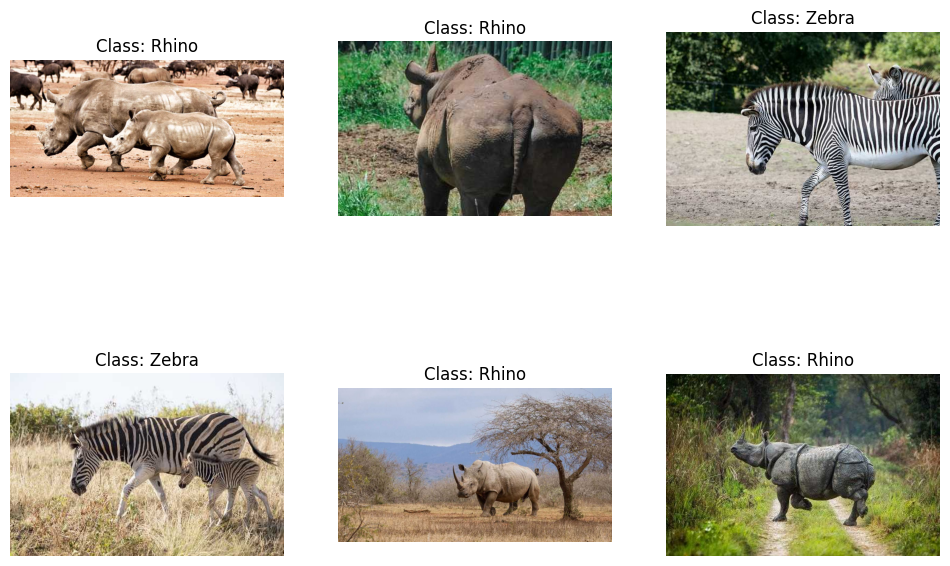

In [ ]:
# Select a few random images
sample_images = random.sample(list(df["image"]), 6)

plt.figure(figsize=(12, 8))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)

    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    actual_class = df[df["image"] == img_name]["class_name"].values[0]  # Get label

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Class: {actual_class}")

plt.show()


### **6. Prepare Dataset for Training**

The code below does the following:
* Defines image properties and preprocesses data.
* Resizes images and converts labels to integer format.
* Splits data into 80% training and 20% validation.
* Loads, resizes, and normalizes images.
* Converts DataFrame to TensorFlow dataset.

In [ ]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
NUM_CLASSES = len(class_mapping)

# Convert labels to categorical (one-hot encoding)
df["label"] = df["label"].astype(int)

# Train-Test Split (80% training, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Function to load and preprocess images
def load_image(img_name, label):
    img_path = os.path.join(train_img_dir, img_name.decode("utf-8"))
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0

    img = img.astype(np.float32)
    label = label.astype(np.float32)

    return img, label

# Convert DataFrame to TensorFlow Dataset
def df_to_dataset(df, batch_size=32, shuffle=True):
    img_names = df["image"].values
    labels = df["label"].values
    labels = to_categorical(labels, num_classes=NUM_CLASSES)

    dataset = tf.data.Dataset.from_tensor_slices((img_names, labels))

    def process_fn(x, y):
        img, label = tf.numpy_function(load_image, [x, y], [tf.float32, tf.float32])
        img.set_shape((150, 150, 3))
        label.set_shape((NUM_CLASSES,))
        return img, label

    dataset = dataset.map(process_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create train and validation datasets
train_dataset = df_to_dataset(train_df)
val_dataset = df_to_dataset(val_df, shuffle=False)

In [ ]:
# Check dataset structure
for img_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", label_batch.shape)


Image batch shape: (32, 150, 150, 3)
Label batch shape: (32, 4)


* The image batch contains 32 images, each sized 150x150 pixels, with 3 color channels (RGB).

* :The label batch contains 32 labels, each having 4 values (one-hot encoding for 4 classes in our case)



## **Build the model**
### **7.1 Define CNN Model Architecture**

The code below:
* Defines a Convolutional Neural Network (CNN) model, using three convolutional layers followed by pooling layers.
* Has a fully connected layer and softmax activation for classification.

In [ ]:
# Define CNN architecture
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Softmax for multi-class classification
])

# Compile model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Show model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Based on the output each layer has its own function:

* **Conv2D Layers (Convolutional Layers)**:

These layers are used to extract features from the input images. They use filters to slide over the image and detect patterns like edges, textures, etc.

* **MaxPooling2D Layers:**

These layers reduce the spatial dimensions (height and width) of the feature maps while retaining important information. This helps to reduce the computational load and helps prevent overfitting.

* **Flatten Layer:**

This layer flattens the 3D output (height, width, channels) of the last Conv2D layer into a 1D array, making it suitable for the Dense (Fully Connected) Layers.

* **Dense Layers (Fully Connected Layers):**

These layers are used for classification. The first Dense layer has 128 neurons, and the last Dense layer has 4 neurons, which is the number of output classes for classification.

In [ ]:
# Check model input shape
print("Model input shape:", model.input_shape)


Model input shape: (None, 150, 150, 3)


The model expects images of size 150x150 pixels. Each image should have 3 color channels (RGB). The batch size is flexible and can be any number (None means the model can handle a batch of any size).

### **7.2. Train the Model**

The code below trains the model for 10 epochs.

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3815 - loss: 1.5794 - val_accuracy: 0.4905 - val_loss: 1.1538
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5681 - loss: 1.0046 - val_accuracy: 0.5476 - val_loss: 0.9831
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6423 - loss: 0.8490 - val_accuracy: 0.5857 - val_loss: 1.0756
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7173 - loss: 0.7522 - val_accuracy: 0.6333 - val_loss: 1.0185
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7582 - loss: 0.6304 - val_accuracy: 0.6667 - val_loss: 1.0076
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8237 - loss: 0.4517 - val_accuracy: 0.6476 - val_loss: 0.8998
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8694 - loss: 0.3399 - val_accuracy: 0.6952 - val_loss: 0.9106
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9288 - loss: 0.2251 - val_accuracy: 0.6762 - val_loss:

## **Evaluate the performance of the CNN using accuracy and loss metrics on a validation dataset. (10M)**


### **7.3 Validate the model**

* During training, the model achieved an accuracy of **65.67%** with a loss of **1.7452**.  

* On the validation set, the model performed slightly better, reaching **69.05%** accuracy with a lower loss of **1.4790**.

In [ ]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.6567 - loss: 1.7452
Validation Loss: 1.4790
Validation Accuracy: 0.6905


### **7.4 Visualize the loss and accuracy**

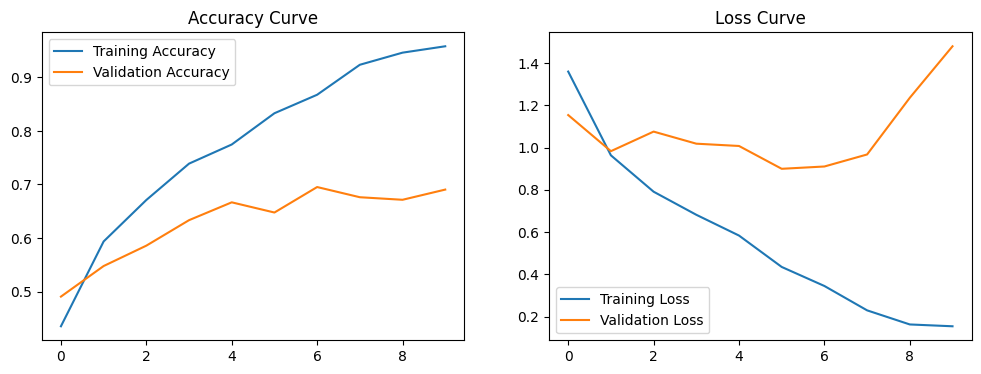

In [ ]:
# Extract loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()


For the accuracy curve:
* The training accuracy increases steadily, reaching above 90%, indicating that the model is learning well on the training data.
* The validation accuracy also increases initially but plateaus around 70%.

For the loss curve:
* The training loss decreases consistently, showing effective learning.
* The validation loss initially decreases but then starts to fluctuate.

## **8.Test and predict the model**
### **Random Test Image Prediction and Comparison**

The code below help us to test the model on the test data and later predict. At the end out of the 5 random test images chosen 1 was predicted incorrectly.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


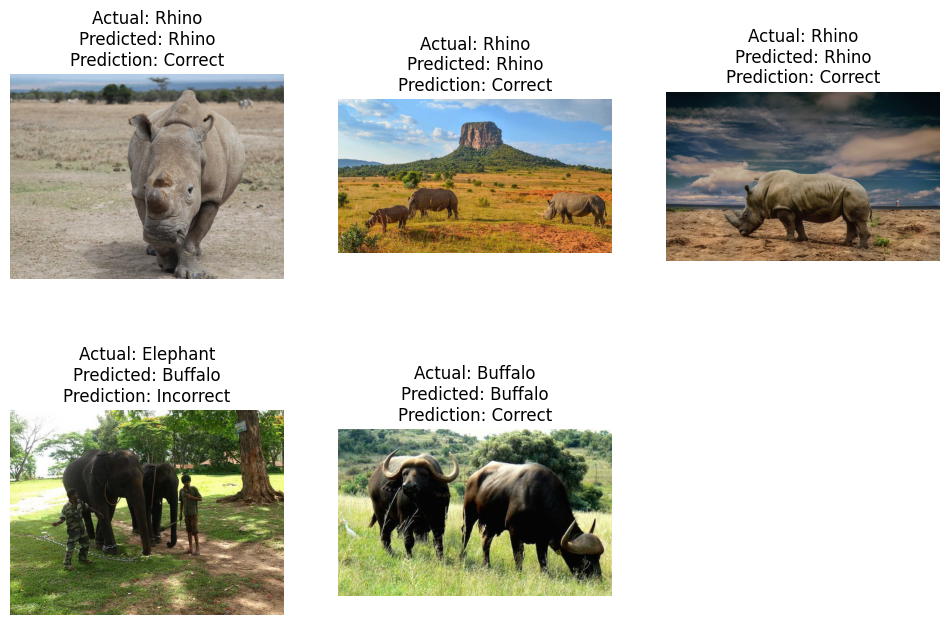

In [ ]:
# Function to preprocess and predict on test images
def preprocess_test_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150)) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_image(img_path, model):
    img = preprocess_test_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return class_mapping[predicted_class]

# Path to test images directory
test_img_dir = "/content/african-wildlife/test/images"

# Get list of all test images
test_images = os.listdir(test_img_dir)

# Select a few random test images
num_random_images = 5
random_test_images = random.sample(test_images, num_random_images)

# Create a figure for displaying the images and results
plt.figure(figsize=(12, 8))

# Predict and compare with actual label for each selected test image
for i, img_name in enumerate(random_test_images):
    img_path = os.path.join(test_img_dir, img_name)

    # Extract the actual class from the label file
    label_file = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(test_img_dir.replace("images", "labels"), label_file)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            actual_class_id = int(lines[0].split()[0])
            actual_class = class_mapping[actual_class_id]

        # Make prediction
        predicted_class = predict_image(img_path, model)

        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image with both actual and predicted class labels
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\n"
                  f"Prediction: {'Correct' if predicted_class == actual_class else 'Incorrect'}")
    else:
        print(f"Label file for {img_name} not found.")

plt.show()


### **8.2 Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


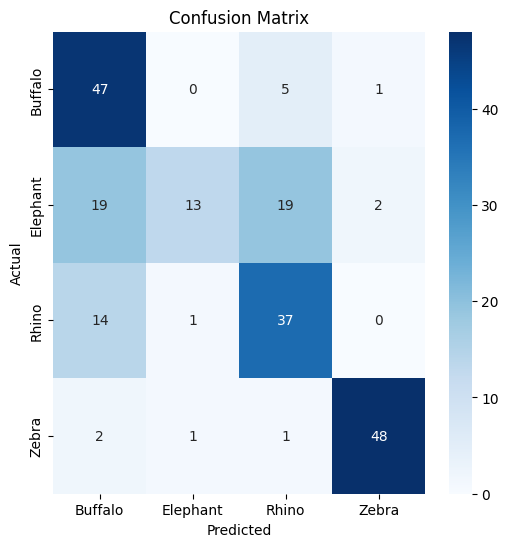

In [ ]:
# Get true labels and predictions
y_true = []
y_pred = []

for img_batch, label_batch in val_dataset:
    preds = model.predict(img_batch)
    y_true.extend(np.argmax(label_batch.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### **Summary of the Confusion Matrix**  

The confusion matrix shows how well the model classifies four animal classes: Buffalo, Elephant, Rhino, and Zebra.  

1. **Correct Predictions (True Positives):**  
   - The model correctly identified most Buffalo (47), Rhino (37), and Zebra (48).  
   - It struggled with Elephants, correctly classifying only 13.  

2. **Misclassifications:**  
   - Elephants were often confused with Buffalo and Rhino.  
   - Some Rhinos were misclassified as Buffalo.  
   - Buffalo and Zebra had fewer mistakes.  

  
* The model performs well for Buffalo and Zebra.  
* Elephants are the hardest to classify accurately.  
* Some Rhinos are mistaken for Buffalo.  



